<a href="https://colab.research.google.com/github/ethvedbitdesjan/NLP/blob/main/Fine_tuning_LayoutLMv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune `LayoutLMv2ForTokenClassification` on the [CORD](https://github.com/clovaai/cord) dataset. The goal for the model is to label words appearing in scanned documents (namely, receipts) appropriately. This task is treated as a NER problem (sequence labeling). However, compared to BERT, LayoutLMv2 also incorporates visual and layout information about the tokens when encoding them into vectors. This makes the LayoutLMv2 model very powerful for document understanding tasks.

LayoutLMv2 is itself an upgrade of LayoutLM. The main novelty of LayoutLMv2 is that it also pre-trains visual embeddings, whereas the original LayoutLM only adds visual embeddings during fine-tuning.

* Paper: https://arxiv.org/abs/2012.14740
* Original repo: https://github.com/microsoft/unilm/tree/master/layoutlmv2

NOTES: 

* you first need to prepare the CORD dataset for LayoutLMv2. For that, check out the notebook "Prepare CORD for LayoutLMv2".
* this notebook is heavily inspired by [this Github repository](https://github.com/omarsou/layoutlm_CORD), which fine-tunes both BERT and LayoutLM (v1) on the CORD dataset.



## Install dependencies

First, we install the required libraries:
* Transformers (for the LayoutLMv2 model)
* Datasets (for data preprocessing)
* Seqeval (for metrics)
* Detectron2 (which LayoutLMv2 requires for its visual backbone).



In [1]:
!rm -r transformers
!git clone -b modeling_layoutlmv2_v2 https://github.com/NielsRogge/transformers.git
!cd tranformers
!pip install -q ./transformers

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 156369, done.
remote: Counting objects: 100% (965/965), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 156369 (delta 638), reused 711 (delta 490), pack-reused 155404
Receiving objects: 100% (156369/156369), 128.69 MiB | 17.06 MiB/s, done.
Resolving deltas: 100% (116052/116052), done.
/bin/bash: line 0: cd: tranformers: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metad

In [2]:
!pip install -q datasets seqeval

     |████████████████████████████████| 451 kB 40.5 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 132 kB 76.5 MB/s 
     |████████████████████████████████| 212 kB 25.8 MB/s 
     |████████████████████████████████| 127 kB 63.9 MB/s 


In [3]:
"""
!sudo apt install tesseract-ocr
!pip install pytesseract
"""

'\n!sudo apt install tesseract-ocr\n!pip install pytesseract\n'

In [4]:
"""
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime
"""

'\n!pip install pyyaml==5.1\n# workaround: install old version of pytorch since detectron2 hasn\'t released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)\n!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html\n\n# install detectron2 that matches pytorch 1.8\n# See https://detectron2.readthedocs.io/tutorials/install.html for instructions\n!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html\n# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime\n'

In [5]:
import torch
print(torch.__version__)

1.8.0+cu101


## Prepare the data

First, let's read in the annotations which we prepared in the other notebook. These contain the word-level annotations (words, labels, normalized bounding boxes).

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
%cd '/content/gdrive/MyDrive/Resume_Info_Extraction/'

/content/gdrive/MyDrive/Resume_Info_Extraction


In [8]:
import pandas as pd

train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

Let's define a list of all unique labels. For that, let's first count the number of occurrences for each label:

In [9]:
from collections import Counter

all_labels = [item for sublist in train[3] for item in sublist] + [item for sublist in test[3] for item in sublist]
Counter(all_labels)

Counter({'Name': 17,
         'Other': 148,
         'Universities': 23,
         'Skills': 46,
         'Past_Companies': 45,
         'Email': 14,
         'Phone': 14,
         'Degrees': 26,
         'Designations': 54})

As we can see, there are some labels that contain very few examples. Let's replace them by the "neutral" label "O" (which stands for "Outside").

In [10]:
all_labels = [item for sublist in train[3] for item in sublist] + [item for sublist in test[3] for item in sublist]
Counter(all_labels)

Counter({'Name': 17,
         'Other': 148,
         'Universities': 23,
         'Skills': 46,
         'Past_Companies': 45,
         'Email': 14,
         'Phone': 14,
         'Degrees': 26,
         'Designations': 54})

Now we have to save all the unique labels in a list.

In [11]:
labels = list(set(all_labels))
print(labels)

['Universities', 'Designations', 'Other', 'Skills', 'Phone', 'Degrees', 'Past_Companies', 'Email', 'Name']


In [12]:
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)

{'Universities': 0, 'Designations': 1, 'Other': 2, 'Skills': 3, 'Phone': 4, 'Degrees': 5, 'Past_Companies': 6, 'Email': 7, 'Name': 8}
{0: 'Universities', 1: 'Designations', 2: 'Other', 3: 'Skills', 4: 'Phone', 5: 'Degrees', 6: 'Past_Companies', 7: 'Email', 8: 'Name'}


In [13]:

from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image

class ResumeDataset(Dataset):
    """CORD dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        image_file_names_temp, self.words, self.boxes, self.labels = annotations
        self.image_dir = image_dir
        self.image_file_names = [f[-10:] for f in image_file_names_temp]
        self.processor = processor

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)
        
        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, 
                                        padding="max_length", truncation=True, 
                                        return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [14]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

train_dataset = ResumeDataset(annotations=train,
                            image_dir='/content/gdrive/MyDrive/Resume_Info_Extraction/Images/', 
                            processor=processor)
test_dataset = ResumeDataset(annotations=test,
                            image_dir='/content/gdrive/MyDrive/Resume_Info_Extraction/Images/', 
                            processor=processor)

Downloading:   0%|          | 0.00/135 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/707 [00:00<?, ?B/s]

Let's verify an example:

In [15]:
encoding = train_dataset[0]
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'image'])

In [16]:
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([512])
token_type_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
image torch.Size([3, 224, 224])


In [17]:
print(processor.tokenizer.decode(encoding['input_ids']))

[CLS] nicole winowiec objective education university of colorado boulder grand valley state university license state of colorado professional teaching license expires : 3 / 2016 special education generalist state of michigan teaching license expires : 6 / 2014 special education k - 12 general education k - 5 endorsements : cognitive impairment & emotional impairment accomplishments + initiated, developed, and taught school to work program at horizon hs + nominee for the iva dean cook teacher of the year award ( through dcdt ) seedpaths llc colorado disability benefit supports program winowien @ gmail. com ( 586 ) 855 - 2445 masters in curriculum and instruction, math and science psychology / special education major director of employment disability advocate [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [18]:
train[1][0]

['Nicole Winowiec',
 'Objective',
 'Education',
 'University of Colorado Boulder',
 'Grand Valley State University',
 'License',
 'State of Colorado Professional Teaching License Expires: 3/2016  Special Education Generalist',
 'State of Michigan Teaching License Expires: 6/2014  Special Education k-12 General Education k-5  Endorsements: Cognitive Impairment & Emotional Impairment',
 'Accomplishments  + Initiated, developed, and taught School to Work program at Horizon HS  + Nominee for the Iva Dean Cook Teacher of the Year Award (through DCDT)',
 'SeedPaths LLC',
 'Colorado Disability Benefit Supports Program',
 'Winowien@gmail.com',
 '(586) 855-2445',
 'Masters in Curriculum and Instruction, Math and Science',
 'Psychology/ Special Education Major',
 'Director of Employment',
 'Disability Advocate']

In [19]:
train[3][0]

['Name',
 'Other',
 'Other',
 'Other',
 'Universities',
 'Other',
 'Skills',
 'Skills',
 'Other',
 'Past_Companies',
 'Past_Companies',
 'Email',
 'Phone',
 'Degrees',
 'Degrees',
 'Designations',
 'Designations']

In [20]:
[id2label[label] for label in encoding['labels'].tolist() if label != -100]

['Name',
 'Other',
 'Other',
 'Other',
 'Universities',
 'Other',
 'Skills',
 'Skills',
 'Other',
 'Past_Companies',
 'Past_Companies',
 'Email',
 'Phone',
 'Degrees',
 'Degrees',
 'Designations',
 'Designations']

In [21]:
for id, label in zip(encoding['input_ids'][:30], encoding['labels'][:30]):
  print(processor.tokenizer.decode([id]), label.item())

[CLS] -100
nicole 8
win -100
##ow -100
##iec -100
objective 2
education 2
university 2
of -100
colorado -100
boulder -100
grand 0
valley -100
state -100
university -100
license 2
state 3
of -100
colorado -100
professional -100
teaching -100
license -100
ex -100
##pire -100
##s -100
: -100
3 -100
/ -100
2016 -100
special -100


Next, we create corresponding dataloaders.

In [22]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

## Train the model

Let's train the model using native PyTorch. We use the AdamW optimizer with learning rate = 5e-5 (this is a good default value when fine-tuning Transformer-based models).



In [23]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm

model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                                      num_labels=len(labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 15

#put the model in training mode
model.train() 
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   for batch in tqdm(train_dataloader):
        # get the inputs;
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss
        
        # print loss every 100 steps
        if global_step % 1 == 0:
          print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

Downloading:   0%|          | 0.00/802M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.5.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.8.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.17.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.1.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.20.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.9.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.0.shortcut.norm.num_batches_tra

Epoch: 0


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 0 steps: 2.1743831634521484
Loss after 1 steps: 2.07308030128479
Loss after 2 steps: 2.122288703918457
Loss after 3 steps: 1.8981056213378906
Loss after 4 steps: 2.106645107269287
Loss after 5 steps: 1.9225530624389648
Loss after 6 steps: 2.023803234100342
Epoch: 1


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 7 steps: 1.9964467287063599
Loss after 8 steps: 2.0816195011138916
Loss after 9 steps: 2.113042116165161
Loss after 10 steps: 1.7703768014907837
Loss after 11 steps: 2.095562219619751
Loss after 12 steps: 1.7986942529678345
Loss after 13 steps: 1.671588659286499
Epoch: 2


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 14 steps: 1.862890362739563
Loss after 15 steps: 2.092928409576416
Loss after 16 steps: 1.6381515264511108
Loss after 17 steps: 1.7067939043045044
Loss after 18 steps: 1.9043419361114502
Loss after 19 steps: 1.9864288568496704
Loss after 20 steps: 1.9822741746902466
Epoch: 3


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 21 steps: 1.8928027153015137
Loss after 22 steps: 1.5680675506591797
Loss after 23 steps: 1.6262784004211426
Loss after 24 steps: 1.8252904415130615
Loss after 25 steps: 1.7566161155700684
Loss after 26 steps: 1.8556134700775146
Loss after 27 steps: 1.8627777099609375
Epoch: 4


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 28 steps: 1.8715325593948364
Loss after 29 steps: 1.5608699321746826
Loss after 30 steps: 1.5916293859481812
Loss after 31 steps: 1.5588575601577759
Loss after 32 steps: 1.5545011758804321
Loss after 33 steps: 1.6753342151641846
Loss after 34 steps: 1.8685916662216187
Epoch: 5


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 35 steps: 1.4735784530639648
Loss after 36 steps: 1.555911898612976
Loss after 37 steps: 1.6342495679855347
Loss after 38 steps: 1.533327341079712
Loss after 39 steps: 1.5127699375152588
Loss after 40 steps: 1.707088589668274
Loss after 41 steps: 1.7047039270401
Epoch: 6


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 42 steps: 1.4232580661773682
Loss after 43 steps: 1.4948318004608154
Loss after 44 steps: 1.5461249351501465
Loss after 45 steps: 1.5768513679504395
Loss after 46 steps: 1.3936450481414795
Loss after 47 steps: 1.5292366743087769
Loss after 48 steps: 1.2877631187438965
Epoch: 7


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 49 steps: 1.4241584539413452
Loss after 50 steps: 1.3026940822601318
Loss after 51 steps: 1.2866339683532715
Loss after 52 steps: 1.3200055360794067
Loss after 53 steps: 1.3846139907836914
Loss after 54 steps: 1.395477294921875
Loss after 55 steps: 1.3023313283920288
Epoch: 8


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 56 steps: 1.3440601825714111
Loss after 57 steps: 1.214990258216858
Loss after 58 steps: 1.2179540395736694
Loss after 59 steps: 1.1807341575622559
Loss after 60 steps: 1.321868658065796
Loss after 61 steps: 1.35157310962677
Loss after 62 steps: 1.1291943788528442
Epoch: 9


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 63 steps: 1.0773897171020508
Loss after 64 steps: 1.2305939197540283
Loss after 65 steps: 1.2104291915893555
Loss after 66 steps: 1.0226846933364868
Loss after 67 steps: 1.110990285873413
Loss after 68 steps: 1.2291070222854614
Loss after 69 steps: 1.013529658317566
Epoch: 10


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 70 steps: 1.1414477825164795
Loss after 71 steps: 1.1050302982330322
Loss after 72 steps: 1.0359033346176147
Loss after 73 steps: 0.9338309168815613
Loss after 74 steps: 0.9486802220344543
Loss after 75 steps: 1.0977122783660889
Loss after 76 steps: 1.0740833282470703
Epoch: 11


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 77 steps: 1.010759711265564
Loss after 78 steps: 1.0242564678192139
Loss after 79 steps: 0.9431523680686951
Loss after 80 steps: 0.9073264002799988
Loss after 81 steps: 0.9909905791282654
Loss after 82 steps: 0.9638912677764893
Loss after 83 steps: 0.958010196685791
Epoch: 12


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 84 steps: 0.9660664796829224
Loss after 85 steps: 0.878638744354248
Loss after 86 steps: 0.9515243768692017
Loss after 87 steps: 1.0712825059890747
Loss after 88 steps: 0.942558765411377
Loss after 89 steps: 0.9003891944885254
Loss after 90 steps: 0.8316663503646851
Epoch: 13


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 91 steps: 1.1945217847824097
Loss after 92 steps: 0.8738102316856384
Loss after 93 steps: 0.9410319924354553
Loss after 94 steps: 0.8636325001716614
Loss after 95 steps: 0.8441981077194214
Loss after 96 steps: 0.889834463596344
Loss after 97 steps: 0.9374005198478699
Epoch: 14


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 98 steps: 0.9257102608680725
Loss after 99 steps: 0.8552703261375427
Loss after 100 steps: 0.8406574726104736
Loss after 101 steps: 0.867888331413269
Loss after 102 steps: 0.781867504119873
Loss after 103 steps: 0.8985710144042969
Loss after 104 steps: 0.967344343662262


In [24]:
loss.item()

0.967344343662262

## Evaluation

Let's evaluate the model on the test set. First, let's do a sanity check on the first example of the test set.

In [25]:
encoding = test_dataset[0]
processor.tokenizer.decode(encoding['input_ids'])

"[CLS] ameya zambre technical skills + java, jamseript, objective - c, c, html / css, sql + sdeveloper, eelipse, xcod, cleaess, subversion ms. computer science + elnthmsan monitor : a solution to monitor a move website for latest movies and aso to search in existing movies sing website's rest services. published on chrame wetstoe with 2500 + users. code avalale on github ( zam - brey ). avascript, html / css ) + zambrey. github. jo : a responsive personal webpage not using any existing responsive frameworks ( angular3s, html / cs8 ) 4 + salaread : a visualization tol for public sla data of georgia tech fcuty. we imported and cleaned up duby available salaries data of last 4 years to google fusion tables. utilizing that we developed an interactive visualization system using google charts plotting data agsinst various parameters to provide more isiht to the gata ( lavascript ( html / css ), google charts, google fusion tables ) 1 + volcedtext logger : an application which trnseribes skyp

In [26]:
ground_truth_labels = [id2label[label] for label in encoding['labels'].squeeze().tolist() if label != -100]
print(ground_truth_labels)

['Other', 'Skills', 'Degrees', 'Other', 'Other', 'Other', 'Email', 'Phone', 'Past_Companies', 'Designations', 'Past_Companies', 'Designations', 'Past_Companies', 'Other', 'Universities', 'Degrees', 'Universities']


In [27]:
for k,v in encoding.items():
  encoding[k] = v.unsqueeze(0).to(device)

model.eval()
# forward pass
outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'],
                token_type_ids=encoding['token_type_ids'], bbox=encoding['bbox'],
                image=encoding['image'])

In [28]:
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
print(prediction_indices)

[2, 8, 8, 8, 8, 8, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 6, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 1, 1, 1, 1, 1, 6, 6, 1, 

In [29]:
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
predictions = [id2label[label] for gt, label in zip(encoding['labels'].squeeze().tolist(), prediction_indices) if gt != -100]
print(predictions)

['Name', 'Skills', 'Skills', 'Other', 'Other', 'Other', 'Email', 'Phone', 'Past_Companies', 'Designations', 'Past_Companies', 'Designations', 'Past_Companies', 'Designations', 'Skills', 'Other', 'Other']


In [30]:
test = pd.read_pickle('test.pkl')

test_dataset = ResumeDataset(annotations=test,
                            image_dir='/content/gdrive/MyDrive/Resume_Info_Extraction/Images/', 
                            processor=processor)
test_dataloader = DataLoader(test_dataset, batch_size=2)

In [31]:
len(test_dataset), len(test_dataloader)

(4, 2)

In [50]:
import numpy as np

preds_val = None
out_label_ids = None

# put model in evaluation mode
count = 0
model.eval()
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                        token_type_ids=token_type_ids, labels=labels)
        
        if preds_val is None:
          preds_val = outputs.logits.detach().cpu().numpy()
          out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
          preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
          out_label_ids = np.append(
              out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
          )

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

In [51]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [52]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.7837837837837838, 'recall': 0.8055555555555556, 'f1': 0.7945205479452055}
               precision    recall  f1-score   support

          ame       0.75      1.00      0.86         3
ast_Companies       0.86      0.86      0.86         7
       egrees       1.00      0.50      0.67         4
  esignations       0.75      0.86      0.80         7
         hone       1.00      1.00      1.00         3
        kills       0.50      0.80      0.62         5
         mail       1.00      1.00      1.00         3
  niversities       1.00      0.50      0.67         4

    micro avg       0.78      0.81      0.79        36
    macro avg       0.86      0.81      0.81        36
 weighted avg       0.83      0.81      0.79        36



In [35]:
%cd 'Images/'

/content/gdrive/MyDrive/Resume_Info_Extraction/Images


In [36]:
from PIL import Image, ImageDraw, ImageFont

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

Downloading:   0%|          | 0.00/135 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [37]:
image = Image.open("image1.jpg")
image = image.convert("RGB")

encoding = processor(image, return_offsets_mapping=True, return_tensors="pt", padding = "max_length", truncation=True)
offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])


In [38]:
for k,v in encoding.items():
  encoding[k] = v.to(device)

outputs = model(**encoding)
print(outputs.logits.shape)

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = image.size

torch.Size([1, 512, 9])


In [39]:
import numpy as np

is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

print(true_predictions)
print(true_boxes)

['Skills', 'Name', 'Name', 'Other', 'Designations', 'Designations', 'Designations', 'Other', 'Past_Companies', 'Skills', 'Skills', 'Other', 'Skills', 'Past_Companies', 'Designations', 'Skills', 'Designations', 'Skills', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Skills', 'Skills', 'Skills', 'Other', 'Skills', 'Skills', 'Other', 'Skills', 'Skills', 'Other', 'Skills', 'Skills', 'Skills', 'Other', 'Degrees', 'Designations', 'Designations', 'Other', 'Designations', 'Designations', 'Designations', 'Other', 'Skills', 'Skills', 'Skills', 'Other', 'Degrees', 'Skills', 'Skills', 'Skills', 'Skills', 'Other', 'Other', 'Other', 'Other', 'Name', 'Name', 'Other', 'Skills', 'Other', 'Other', 'Skills', 'Skills', 'Other', 'Skills', 'Skills', 'Skills', 'Skills', 'Skills', 'Other', 'Skills', 'Past_Companies', 'Skills', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Universities', 'Skills', 'Skills', 'Other', 'Degrees', 'Ot

In [40]:
tokens = encoding.tokens()

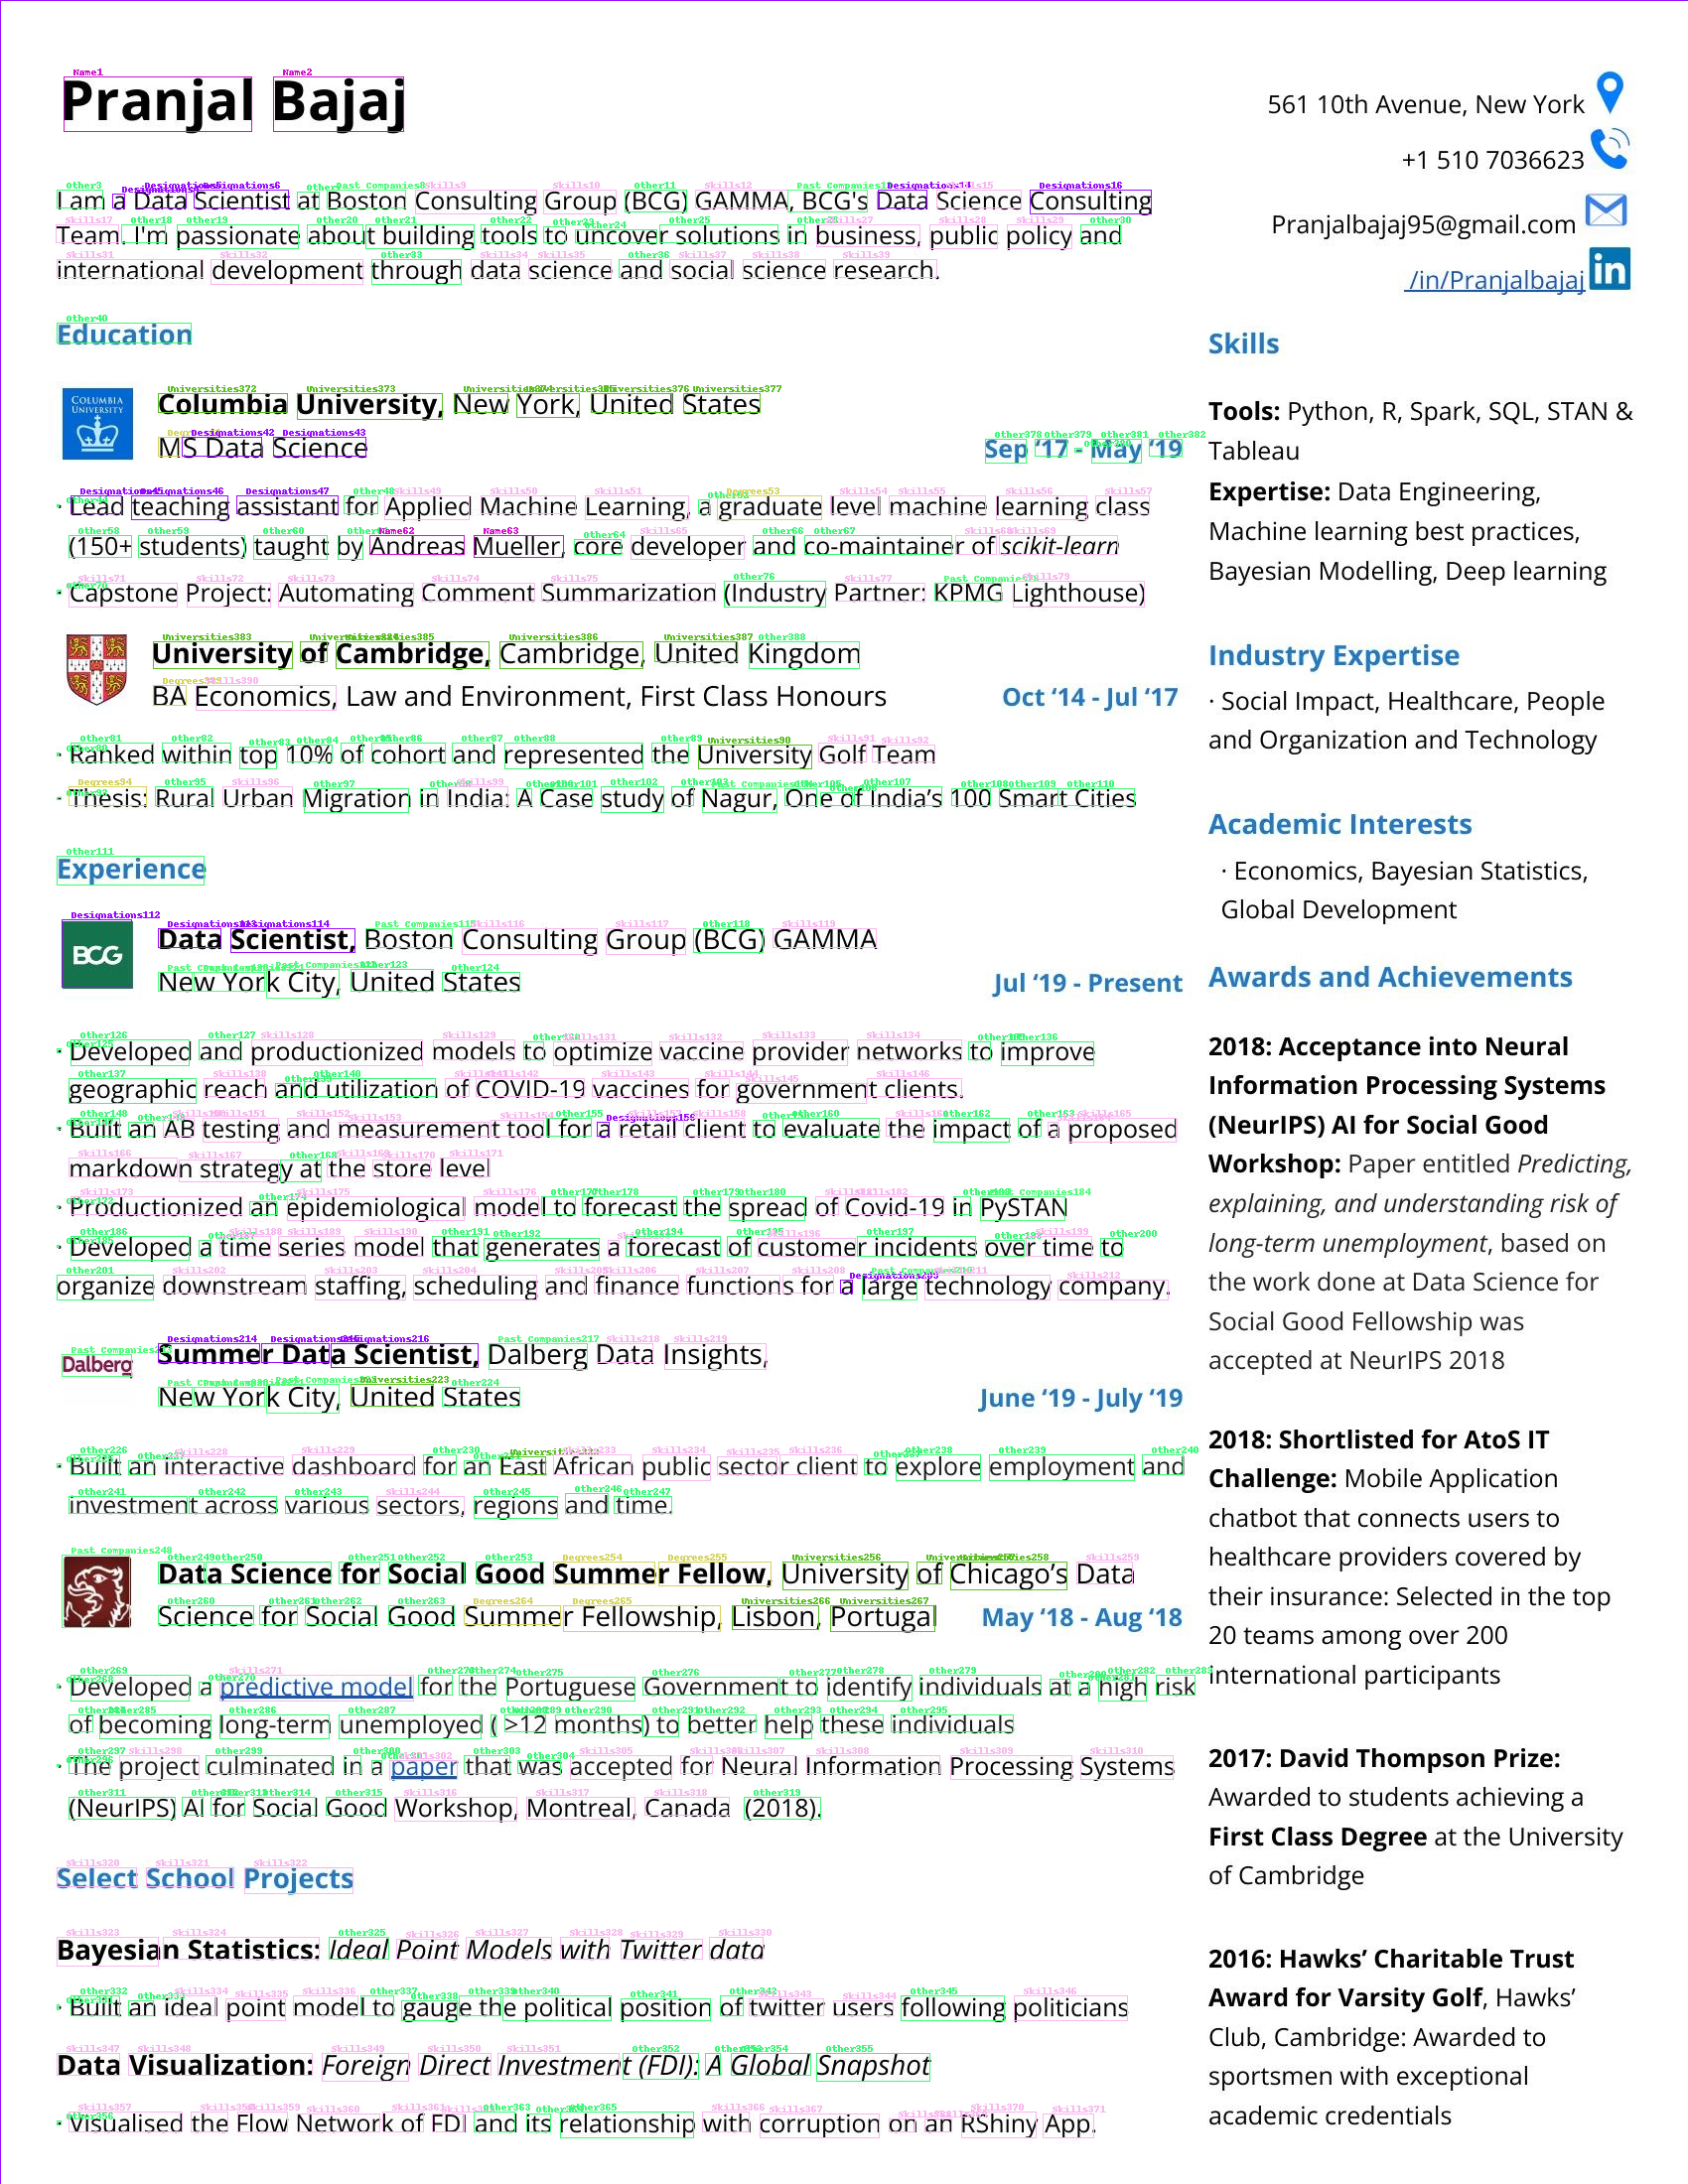

In [41]:
import random
from PIL import ImageDraw

get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(labels))
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label
    if not label:
      return 'other'
    return label

label2color = {label: colors[idx] for idx, label in enumerate(labels)}

count = 0
for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label + str(count), fill=label2color[predicted_label], font=font)
    count += 1
image

In [42]:
type(encoding)

transformers.tokenization_utils_base.BatchEncoding

In [43]:
len(encoding.word_ids())

512

In [44]:
tokens[encoding.word_ids()[214]]

'experience'

In [45]:
encoding.words()[:10], encoding.tokens()[:10]

([None, 0, 0, 0, 1, 1, 2, 3, 4, 5],
 ['[CLS]',
  'pr',
  '##an',
  '##jal',
  'baja',
  '##j',
  'lam',
  'a',
  'data',
  'scientist'])

In [46]:
encoding.bbox[0][:10]

tensor([[  0,   0,   0,   0],
        [ 38,  35, 149,  60],
        [ 38,  35, 149,  60],
        [ 38,  35, 149,  60],
        [162,  35, 239,  60],
        [162,  35, 239,  60],
        [ 34,  87,  61,  95],
        [ 67,  89,  74,  95],
        [ 80,  87, 110,  95],
        [115,  87, 171,  95]], device='cuda:0')

In [47]:
for id in encoding.input_ids:
  for i, ident in enumerate(id):
    print(i, processor.tokenizer.decode(ident))

0 [CLS]
1 pr
2 ##an
3 ##jal
4 baja
5 ##j
6 lam
7 a
8 data
9 scientist
10 at
11 boston
12 consulting
13 group
14 (
15 bc
16 ##g
17 )
18 gamma
19 ,
20 bc
21 ##g
22 '
23 s
24 data
25 science
26 consulting
27 team
28 .
29 i
30 '
31 m
32 passionate
33 about
34 building
35 tools
36 to
37 uncover
38 solutions
39 in
40 business
41 ,
42 public
43 policy
44 and
45 international
46 development
47 through
48 data
49 science
50 and
51 social
52 science
53 research
54 .
55 education
56 ms
57 data
58 science
59 -
60 lead
61 teaching
62 assistant
63 for
64 applied
65 machine
66 learning
67 ,
68 a
69 graduate
70 level
71 machine
72 learning
73 class
74 (
75 150
76 +
77 students
78 )
79 taught
80 by
81 andreas
82 mueller
83 ,
84 core
85 developer
86 and
87 co
88 -
89 maintain
90 ##er
91 of
92 sci
93 ##kit
94 -
95 learn
96 -
97 caps
98 ##tone
99 project
100 :
101 auto
102 ##mat
103 ##ing
104 comment
105 sum
106 ##mar
107 ##ization
108 (
109 industry
110 partner
111 :
112 k
113 ##pm
114 ##g
115 lighthouse

In [48]:
encoding.words()[486]

372

In [49]:
tokens[486]

'university'